Óscar Morujo Fernández

# Procesamiento de Lenguaje Natural: Analisis de sentimiento con la aproximación de bag of words.

En esta práctica vamos a usar el fichero “yelp_labelled.txt” que contiene un conjunto de datos de  opiniones  de  restaurantes  del  recomendador  Yelp.
El objetivo es comparar el funcionamiento de distintos clasificadores y entender cómo trabajan estos con texto.

En primer lugar vamos a proceder a importar los datos y a transformarlos a un dataframe con dos columnas:

    -Data: contiene la frase
    -Target: contiene la clase a la que pertenece(0 sentimiento negativo y 1 sentimiento positivo)
   


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#Decision trees
from sklearn import tree
from sklearn.tree import export_graphviz,plot_tree

#IMPORTS NAIVE BAYES
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

In [3]:
df = pd.read_csv("/content/yelp_labelled.txt", sep="\t",header=None)
df.columns = ["Data", "Target"]
df

,Data,Target
0,Wow...Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


Como podemos observar tenemos 1000 reseñas de las cuales 500 son positivas y 500 son negativas.

In [4]:
df['Target'].value_counts()

1    500
0    500
Name: Target, dtype: int64

Ahora procedemos a configurar una partición de tal manera que tengamos el 75% de datos para el entrenamiento y el 25% para la parte de test

In [5]:
X_train, X_test, y_train, y_test= train_test_split(df.Data,df.Target,test_size=0.25,random_state= 333)

##CREATE BAG OF WORDS

A la hora de generar la bolsa de palabras con countVectorizer usamos el diccionario que se genera con los términos del propio corpus y usa la lista de palabras vacías (stop_words)que proporciona sklearn para el inglés. Además,analizaremos el efecto de combinado de dos parámetros analizando en cada uno dos opciones:

    -Bolsa de palabras binaria y bolsa de palabras con TF/IDF (parámetro binary).
    -Usando un rango de n-gramas de (1,1) y de (1,2) con el parámetro ngram_range.
    
En primer lugar aplicaremos las transformaciones en el conjunto de entrenamiento. Tanto el diccionario usado, como el término IDF, debe ser el mismo en los conjuntos de entrenamiento y de test. Por ello,usamos fit_transform para el conjunto de entrenamiento, para fijar el dicccionario en CountVectorizer y el término idf del TfidfTransformer, mientras que usamos transform en el conjunto de test (de forma que ambas herramientas usan lo aprendido en el conjunto de entrenamiento)

-Vectores con frecuencias de las palabras(mas abajo los transformaremos a valores TF/IDF)

In [6]:
#Monogramas
vectorizer1 = CountVectorizer(stop_words='english',binary=False,ngram_range=(1,1))
#Monogramas y bigramas
vectorizer2 = CountVectorizer(stop_words='english',binary=False,ngram_range=(1,2))

-Vectores con valores binarios

In [8]:
#Monogramas
vectorizer3 = CountVectorizer(stop_words='english',binary=True,ngram_range=(1,1))
#Monogramas y bigramas
vectorizer4 = CountVectorizer(stop_words='english',binary=True,ngram_range=(1,2))

In [9]:

# Tomamos los textos del conjunto de entrenamiento y los transformamos en 
# una matriz de datos (palabras)
train_vector_data1=vectorizer1.fit_transform(X_train)
train_vector_data2=vectorizer2.fit_transform(X_train)
train_vector_data3=vectorizer3.fit_transform(X_train)
train_vector_data4=vectorizer4.fit_transform(X_train)


Con la siguiente función podremos ver los términos de los mensajes deseados:

In [10]:
def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data:
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

Como podemos observar a continuación , con los bigramas obtenemos una bolsa de palabras de 4185 elementos, mientras que con los monogramas una de 1472

In [12]:
print("Vectorizer 1 lenght: ")
print(len(vectorizer1.get_feature_names_out()))
print("Vectorizer 2 lenght")
print(len(vectorizer2.get_feature_names_out()))
print("Vectorizer 3 lenght")
print(len(vectorizer3.get_feature_names_out()))
print("Vectorizer 4 lenght")
print(len(vectorizer4.get_feature_names_out()))


Vectorizer 1 lenght: 
1472
Vectorizer 2 lenght
4185
Vectorizer 3 lenght
1472
Vectorizer 4 lenght
4185


Procedemos a calcular los valores TF/IDF para cada termino de los documentos (en este caso solo trabajaremos con estos valores en los conjuntos de entrenamiento 1 y 2, los otros dos serán binarios).

In [13]:
tfidfer1= TfidfTransformer()
tfidfer2= TfidfTransformer()

# Calculamos el valor TF-IDF para cada vector de entrenamiento
train_preprocessed1=tfidfer1.fit_transform(train_vector_data1)
train_preprocessed2=tfidfer2.fit_transform(train_vector_data2)
#Aquellos que usen la presencia o no de la palabra los dejamos igual
train_preprocessed3=train_vector_data3
train_preprocessed4=train_vector_data4

   

In [14]:
# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data1=vectorizer1.transform(X_test)
test_vector_data2=vectorizer2.transform(X_test)
test_vector_data3=vectorizer3.transform(X_test)
test_vector_data4=vectorizer4.transform(X_test)
# Calculamos el valor TF-IDF 
# Al usar "transform" toma como IDF el del conjunto de entrenamiento 
test_preprocessed1=tfidfer1.transform(test_vector_data1)
test_preprocessed2=tfidfer2.transform(test_vector_data2)
#Aquellos que usen la presencia o no de la palabra los dejamos igual
test_preprocessed3=test_vector_data3
test_preprocessed4=test_vector_data4

Ahora ya tenemos los conjuntos de entrenamiento y test preparados para elegir un clasificador y comprobar los resultados

## CLASIFICADORES NAIVE BAYES

En primer lugar vamos a crear una función que nos devuelva el clasificador con sus porcentajes de acierto en test y train, así reducimos la repetición de código:

In [15]:
def naive_bayes_classifier(classification_type,clf_name,train_preprocessed,test_preprocessed):
    clf = classification_type
    clf.fit(train_preprocessed,y_train)
    train_predictions = clf.predict(train_preprocessed)
    test_predictions = clf.predict(test_preprocessed)
    print(clf_name," porcentaje de aciertos en entrenamiento:", np.mean(train_predictions == y_train))
    print(clf_name," porcentaje de aciertos en test:", np.mean(test_predictions == y_test))
    return clf

In [16]:
def naive_bayes_report(clf,test_preprocessed):
    predictions = clf.predict(test_preprocessed)
    names =["Malos","Buenos"]
    print(classification_report(y_test, predictions, target_names=names))
    

**Vamos a empezar entrenando y analizando nuestro clasificador con el primer vector, el cual usa valores TF/IDF y monogramas. Después de analizar la tasa de aciertos con un clasificador gaussiano y otro multinomial, los cuales funcionan bien cuando usamos valores TF/IDF, hemos visto que la tasa de aciertos es superior en el multinomial.**

&nbsp;

In [17]:
naive_bayes_1 = naive_bayes_classifier(MultinomialNB(),"Multinomial Naive Bayes",
                                       train_preprocessed1,test_preprocessed1)

Multinomial Naive Bayes  porcentaje de aciertos en entrenamiento: 0.968
Multinomial Naive Bayes  porcentaje de aciertos en test: 0.744


In [18]:
naive_bayes_report(naive_bayes_1,test_preprocessed1)

              precision    recall  f1-score   support

       Malos       0.78      0.68      0.72       124
      Buenos       0.72      0.81      0.76       126

    accuracy                           0.74       250
   macro avg       0.75      0.74      0.74       250
weighted avg       0.75      0.74      0.74       250



Cuando predice que son comentarios malos acierta el 78% de las veces, mientras que cuando predice que son buenos acierta el 72% de las veces.
De todos los malos clasifica correctamente el 68%, mientras que de los comentarios buenos el 81%


**Ahora procedemos a crear el segundo vector, el cual consta de valores TF/IDF también, pero en este caso trabajamos con bigramas y monogramas.
El clasificador que usaremos es el multinomial también (depués de haber observado que el gaussiano tiene una menor tasa de aciertos).**

&nbsp;

In [19]:
naive_bayes_2 = naive_bayes_classifier(MultinomialNB(),"Multinomial Naive Bayes",
                                       train_preprocessed2,test_preprocessed2)

Multinomial Naive Bayes  porcentaje de aciertos en entrenamiento: 0.9933333333333333
Multinomial Naive Bayes  porcentaje de aciertos en test: 0.76


In [20]:
naive_bayes_report(naive_bayes_2,test_preprocessed2)

              precision    recall  f1-score   support

       Malos       0.78      0.72      0.75       124
      Buenos       0.74      0.80      0.77       126

    accuracy                           0.76       250
   macro avg       0.76      0.76      0.76       250
weighted avg       0.76      0.76      0.76       250



Con monogramas y bigramas vemos como el porcentaje de precisión en comentarios se mantiene, pero ahora en vez de clasificar correctamente al 68% de los malos, ahora lo hacemos con una precisión de el 72%(exhaustividad).

La precisión de los buenos aumenta ligeramente mientras que la exhaustividad baja 0,1.

Este segundo clasificador es algo superior al primero.

**Ahora procedemos a crear el clasificador de el tercero de los vectores, el cual consta de valores binarios (0 si no está la palabra en esa frase o 1 si lo está), y nuestra bolsa consta de monogramas.**

&nbsp;

Usaremos un clasificador Naive Bayes Bernoulli, el cual que se utiliza cuando es la ausencia de determinadas palabras la que importa


In [21]:
naive_bayes_3 = naive_bayes_classifier(BernoulliNB(),"Bernoulli Naive Bayes",
                                       train_preprocessed3,test_preprocessed3)

Bernoulli Naive Bayes  porcentaje de aciertos en entrenamiento: 0.9586666666666667
Bernoulli Naive Bayes  porcentaje de aciertos en test: 0.756


In [22]:
naive_bayes_report(naive_bayes_3,test_preprocessed3)

              precision    recall  f1-score   support

       Malos       0.78      0.71      0.74       124
      Buenos       0.74      0.80      0.77       126

    accuracy                           0.76       250
   macro avg       0.76      0.76      0.76       250
weighted avg       0.76      0.76      0.76       250



Los resultados son prácticamente los mismos en los que usabamos tf/idf y monogramas y bigramas.

**Ahora crearemos el último clasificador creado para el último vector, el cual tiene valores binarizados y usa monogramas y bigramas.**

&nbsp;

Usamos también un clasificador Naive Bayes Bernoulli

In [23]:
naive_bayes_4 = naive_bayes_classifier(BernoulliNB(),"Bernoulli Naive Bayes",
                                       train_preprocessed4,test_preprocessed4)

Bernoulli Naive Bayes  porcentaje de aciertos en entrenamiento: 0.984
Bernoulli Naive Bayes  porcentaje de aciertos en test: 0.772


In [24]:
naive_bayes_report(naive_bayes_4,test_preprocessed4)

              precision    recall  f1-score   support

       Malos       0.80      0.73      0.76       124
      Buenos       0.75      0.82      0.78       126

    accuracy                           0.77       250
   macro avg       0.77      0.77      0.77       250
weighted avg       0.77      0.77      0.77       250



Este último es el que mejor ha clasificado los comentarios,tantos los buenos como los malos.

## CLASIFICADOR ÁRBOL DE DECISIÓN

Vamos a programar una función que reciba cada uno de los train_preprocessed y test_preproccesed y encuentre el árbol con mejor porcentaje de aciertos en test probando diferentes profundidades.Además nos devuelve una gráfica para ver con más claridad si la profundidad es la más acertada y no está sobreaprendiendo.

In [25]:
def best_decision_tree(train_preprocessed, test_preprocessed):
    
    train_accuracy = []
    test_accuracy = []
    best_test_accuracy=0
    best_tree= None
    i=0
    max_depths = range(2, 200)
    for md in max_depths: 
        # Entrenar y validar
        clf =  tree.DecisionTreeClassifier(splitter="best",criterion="gini", max_depth=md,random_state = 33)
        clf.fit(train_preprocessed,y_train)

        tree_train_predictions = clf.predict(train_preprocessed)
        tree_test_predictions = clf.predict(test_preprocessed)

        train_accuracy.append(np.mean(tree_train_predictions == y_train))
        test_accuracy.append(np.mean(tree_test_predictions == y_test))
        if test_accuracy[i] > best_test_accuracy:
            best_test_accuracy = test_accuracy[i]
            best_train_accuracy = train_accuracy[i]
            best_tree = clf
            best_max_depth = md

        i= i+1
        

        # Draw lines
    plt.plot(max_depths, train_accuracy, color="r",  label="Training")
    plt.plot(max_depths, test_accuracy, color="g", label="Test")

    # Create plot
    plt.title("Curva de aprendizaje")
    plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()  

    print("La mejor profundidad para este arbol es:",best_max_depth)
    print("Árbol, porcentaje de aciertos en entrenamiento:", best_train_accuracy)
    print("Árbol, porcentaje de aciertos en test:", best_test_accuracy)
    
    return best_tree

Función para pintar los árboles:

In [26]:
def print_tree(tree_classifier,vector_feature_names,max_depth_to_print):
    plt.figure(figsize=(50,50))
    names =["Malos","Buenos"]
    plot_tree(tree_classifier, filled=True, feature_names=vector_feature_names, class_names=names,
          max_depth = max_depth_to_print,rounded=True,fontsize=15)
    plt.show()
    print()

In [27]:
def decision_tree_report(clf,test_preprocessed):
    predictions = clf.predict(test_preprocessed)
    names =["Malos","Buenos"]
    print(classification_report(y_test, predictions, target_names=names))

Funciones para pintar las 25 variables más significativas:

In [28]:
def print_top25_features_in_trees(vectorizer, clf):
    """Prints features with the highest coefficient values"""
    feature_names = vectorizer.get_feature_names()
    
    top25 = np.argsort(clf.feature_importances_)[-25:]
    reversed_top = top25[::-1]
    print("Top 25 features in the tree\n")
    print("%s" % ( " / ".join(feature_names[j] for j in reversed_top)))

In [29]:
def print_top25_features_per_class_in_NB(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    print("Top 25 features per class\n")
    for i, class_label in enumerate(class_labels):
        top25 = np.argsort(clf.feature_log_prob_[i])[-25:]
        reversed_top = top25[::-1]
        
        print("%s: %s" % (class_label,
              " / ".join(feature_names[j] for j in reversed_top)),'\n')
        
        #Descomentar para ver el índice de los términos en el diccionario
        #print("%s " % (" / ".join(str(j) for j in reversed_top)),'\n')

**En primer lugar buscamos un árbol de decisión para el primer conjunto (monogramas y valores tf/idf) con ayuda de gridSearch para encontrar la profundidad máxima que maximize la tasa de aciertos.**

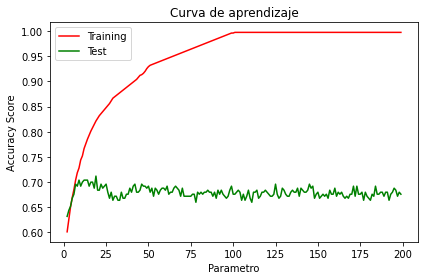

La mejor profundidad para este arbol es: 19
Árbol, porcentaje de aciertos en entrenamiento: 0.8213333333333334
Árbol, porcentaje de aciertos en test: 0.712


In [30]:
best_tree_1 = best_decision_tree(train_preprocessed1,test_preprocessed1)

In [31]:
decision_tree_report(best_tree_1,test_preprocessed1)

              precision    recall  f1-score   support

       Malos       0.66      0.88      0.75       124
      Buenos       0.82      0.55      0.66       126

    accuracy                           0.71       250
   macro avg       0.74      0.71      0.70       250
weighted avg       0.74      0.71      0.70       250



**Monogramas y bigramas con valores tf/idf.**

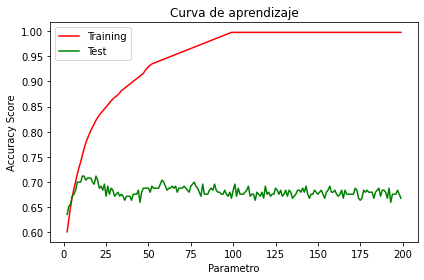

La mejor profundidad para este arbol es: 11
Árbol, porcentaje de aciertos en entrenamiento: 0.7533333333333333
Árbol, porcentaje de aciertos en test: 0.712


In [32]:
best_tree_2 = best_decision_tree(train_preprocessed2,test_preprocessed2)

In [ ]:
decision_tree_report(best_tree_2,test_preprocessed2)

              precision    recall  f1-score   support

       Malos       0.64      0.94      0.76       124
      Buenos       0.90      0.48      0.63       126

    accuracy                           0.71       250
   macro avg       0.77      0.71      0.70       250
weighted avg       0.77      0.71      0.70       250



**Monogramas con valores binarios.**

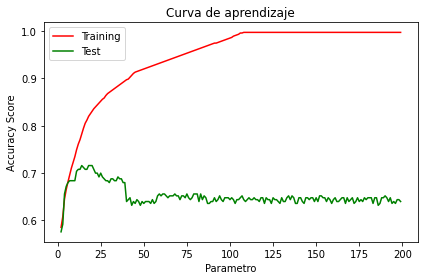

La mejor profundidad para este arbol es: 14
Árbol, porcentaje de aciertos en entrenamiento: 0.7826666666666666
Árbol, porcentaje de aciertos en test: 0.716


In [33]:
best_tree_3 = best_decision_tree(train_preprocessed3,test_preprocessed3)

In [ ]:
decision_tree_report(best_tree_3,test_preprocessed3)

              precision    recall  f1-score   support

       Malos       0.65      0.91      0.76       124
      Buenos       0.86      0.52      0.65       126

    accuracy                           0.72       250
   macro avg       0.76      0.72      0.71       250
weighted avg       0.76      0.72      0.71       250



**Monogramas y bigramas con valores binarios.**

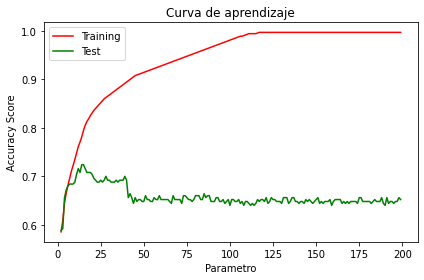

La mejor profundidad para este arbol es: 14
Árbol, porcentaje de aciertos en entrenamiento: 0.7813333333333333
Árbol, porcentaje de aciertos en test: 0.724


In [34]:
best_tree_4 = best_decision_tree(train_preprocessed4,test_preprocessed4)

In [35]:
decision_tree_report(best_tree_4,test_preprocessed4)

              precision    recall  f1-score   support

       Malos       0.66      0.93      0.77       124
      Buenos       0.88      0.52      0.66       126

    accuracy                           0.72       250
   macro avg       0.77      0.73      0.71       250
weighted avg       0.77      0.72      0.71       250



En general los árboles de decisión tienen peores resultados en entrenamiento y en test. Esto significa que es menos adecuado al problema que Naive Bayes. Esto puede ocurrir porque hay muchas palabras que se encuentran en las dos clases de opiniones. Por esto al árbol le cuesta más discriminar las palabras que sean dudosas. Aun así los resultados en test son bastante buenos. Sólo se diferencian un 5% de los resultados en test de Naive Bayes. Esto ocurre porque los árboles de decisión hacen una buena generalización del problema. Este tipo de clasificador vendría bien en los problemas en los que se pudiese producir un fuerte sobreaprendizaje.

***Análisis de la complejidad***

En el caso del clasificador Naive Bayes cuando operamos con TF-IDF empeoran los resultados.
Sin embargo el hecho de utilizar bigramas hace que mejoren los resultados. Esto ocurre porque hay muchos casos como el de la palabra "good" que al ponerse antes una palabra como "not" cambia completamente el sentimiento. Aquí good que en principio tiene un sentimiento bueno le hace tener el sentimiento opuesto. Pero también hay muchos casos de palabras sin sentimiento que con la palabra anterior puede tener un sentimiento u otro. La palabra "like" coge un sentimiento negativo (la mayoria de veces) cuando se pone la palabra "not" delante. Un ejemplo es el bigrama "second time" nos indica que es un sentimiento positivo porque en principio las personas a las que no les ha gustado el restaurante no van a volver.

En los árboles de decisión ocurre lo mismo pero con unas difencias muy pequeñas entre añadir complejidad o no hacerlo.
Además el corpus tiene muchas palabras para que un árbol de decisión no sea la mejor opción a isar aquí, ya que además de que es más lento, probablemente tienda a crecer por la cantidad de palabras que tiene y acabe sobreaprendiendo antes y llevandonos a un mal clasificador.

In [ ]:
#Valores binarios en el vector y monogramas y bigramas
print_top25_features_in_trees(vectorizer4, best_tree_4)

Top 25 features in the tree

great / good / delicious / amazing / fantastic / nice / awesome / friendly / excellent / loved / perfect / love / happy / best / like / helpful / char flavor / priced hip / service poor / gas station / customer service / cheated wasting / bad food / good way / bring small


Curiosamente las palabras con mayor poder discriminante son de sentimiento bueno. Al principio supusimos que palabras como "bad food" solo aparecerían en frases negativas y por lo tanto tendrían un poder dicriminante mayor. Pero no lo tienen porque son muy pocos casos en lo que esto ocurre. Esto puede ocurrir porque a la hora de expresar una opinión negativa utilizamos un mayor conjunto de palabras, mientras que en las opiniones positivas utilizamos con frecuencia palabras como "great", "good", etc. 
A partir de la palabra número 16 ("helpful") la frecuencia de las palabras decrece muchísimo (máximo 4 apariciones) y por lo tanto creemos que el poder discriminante no es significativo y empieza a ir por mal camino(sobreajuste).

In [ ]:
names =["Malos","Buenos"]
print_top25_features_per_class_in_NB(vectorizer4,naive_bayes_4, names)

Top 25 features per class

Malos: food / place / service / like / good / time / don / won / ve / got / bad / worst / just / minutes / came / wasn / disappointed / going / eat / think / pretty / wait / did / way / ll 

Buenos: good / great / food / place / service / delicious / time / amazing / really / nice / best / friendly / just / like / love / vegas / restaurant / awesome / fantastic / staff / excellent / fresh / experience / loved / menu 



El mejor clasificador Naive Bayes es este último, Naive Bayes Bernoulli con bolsa de palabras binaria y uso de monogramas y bigramas. La tasa de aciertos en test es de 0.772 ligeramente por encima del resto de combinaciones.

Este clasificador se diferencia en el multinomial en que este penaliza explícitamente la no ocurrencia de una palabra que debería de aparecer en la frase(que es un indicador de clase) mientras que el multinomial si no aparece una palabra, lo ignora.


De las 25 palabras por clase podemos destacar:

Puede parecer que hay mucho ruido en "Malas" con palabras que pueden ser sin sentimimento, como por ejemplo: ve, got, going, did, ll. Pero lo cierto es que se encuentran en gran cantidad en las frases malas. La palabra "ve" una gran parte de las veces se utiliza en frases como "the worst fries I've ever had". La palabra got suele utilizarse con algo de comida que han servido que no estaba bueno, como "I got food poisoning here at the buffet". En cambio no hay muchas palabras de este estilo en "Buenas".
Los términos food, place, service, time, están presentes con mucha frecuencia en ambos bandos. Como pasa con la palabra good, se encuentra muchas veces en "Malas" porque hay frases como : "it was not goot", "seems like a good place, but..." y esto puede llevar al clasificador a una equivocación.

Así, los comentarios mientras que no tengan presencia de las palabras de la clase Malos se van a clasificar como buenos, y viceversa.Parece la mejor solución a este problema, ya que es más fácil identificar un mal comentario si no tiene palabras de sentimiento positivo, y viceversa.

##ANÁLISIS CLASIFICADORES

El clasificador de Naive Bayes con una mayor tasa de aciertos en el test es cuarto (Naive Bayes Bernoulli con bolsa de palabras con valores binarios y uso de monogramas y bigramas) con un porcentaje de aciertos en entrenamiento de 0.984 y un porcentaje de aciertos en test de 0.772

In [36]:
naive_bayes_report(naive_bayes_4,test_preprocessed4)

              precision    recall  f1-score   support

       Malos       0.80      0.73      0.76       124
      Buenos       0.75      0.82      0.78       126

    accuracy                           0.77       250
   macro avg       0.77      0.77      0.77       250
weighted avg       0.77      0.77      0.77       250



El árbol de decisión con mayor tasa de aciertos en el test es el número cuatro (bolsa de palabras binaria y con monogramas y bigramas) con un porcentaje de aciertos en entrenamiento de 0.78133
y un porcentaje de aciertos en test de 0.724


In [37]:
predictions = best_tree_4.predict(test_preprocessed4)
names =["Malos","Buenos"]
print(classification_report(y_test, predictions, target_names=names))

              precision    recall  f1-score   support

       Malos       0.66      0.93      0.77       124
      Buenos       0.88      0.52      0.66       126

    accuracy                           0.72       250
   macro avg       0.77      0.73      0.71       250
weighted avg       0.77      0.72      0.71       250



###Mejor árbol de decisión (bigramas y valores binarios)


(array([0.5, 1.5]), <a list of 2 Text xticklabel objects>)

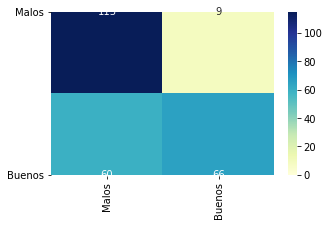

In [ ]:
%matplotlib inline
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=names, columns=names)

plt.figure(figsize=(5, 3))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
#Malos - Malos = 115

Precisión
- Buenos: 88%
- Malos: 66%


Exhaustividad
- Buenos: 52%
- Malos: 93%

No tiene un comportamiento homogéneo. Esto puede ser porque las palabras con mayor poder discriminante son buenas. A la hora de clasificar, el árbol discrimina las buenas estando casi seguro (88% de precisión) de que son buenas ya que contienen las palabras con mayor poder discriminante. Pero las opiniones sobre las que no está claro cual es su sentimiento las clasifica como negativas, de las cuales un 34% son positivas. Esto hace que baje mucho la exhaustividad de las buenas. La ventaja de utilizar este árbol de decisión es que generaliza bastante bien (aciertos en entrenamiento y test aproximados). Pero el incoveniente es que no aprende lo suficientemente bien como para tener mejores resultados en este tipo de problemas.

###Mejor Naive Bayes (bigramas y valores binarios)


(array([0.5, 1.5]), <a list of 2 Text xticklabel objects>)

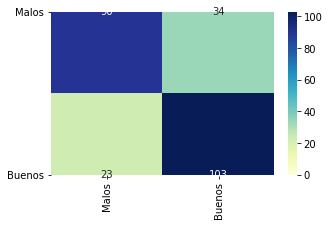

In [ ]:
predictions = naive_bayes_4.predict(test_preprocessed4)


conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=names, columns=names)

plt.figure(figsize=(5, 3))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
#Malos - Malos = 90

Precisión
- Buenos: 75%
- Malos: 80%


Exhaustividad
- Buenos: 82%
- Malos: 73%

Naive Bayes tiene un comportamiento homogéneo a diferencia del árbol de decisión. Al asumir que todas las variables son independientes le puede dar pesos más equilibrados a las palabras a la hora de discriminar. La ventaja que tiene este clasificador es que aprende a discriminar muy bien en entrenamiento. Esto para problemas que se necesite ser específico y que no venga bien generalizar estará bien. En este problema solo conseguimos un 77% de aciertos porque tenemos ese leve sobreaprendizaje en un problema que necesita un poco más de generalización.

***¿Hay algún clasificador que sea mejor que el otro en todo?***
No, pero se puede observar que Naive Bayes es un mejor clasificador porque tiene más homogeneidad. Lo que resulta sorprendente es que hay poca diferencia de aciertos en test. Esto puede ocurrir porque en este tipo de problema viene bien la generalización de los árboles de decisión.

Aún así con Naive Bayes obtenemos unos resultados más "equilibrados",es decir, la exhaustividad y la precisión van mas a la par, mientras que en árboles de decisión estos valores son más alejados.
- Aciertos árbol de decisión en test: 72,4%
- Aciertos Naive Bayes en test: 77,2%


***¿Coinciden ambos clasificadores a la hora de clasificar mejor una clase que la otra?***
Sí, el árbol clasificar mejor las opiniones buenas aunque con baja exhaustividad y Naive Bayes clasifica ligeramente mejor las opiniones buenas. Suponemos que esto puede ser porque las opiniones positivas suelen ser más parecidas entre sí que las negativas.

###Pintamos el arbol:

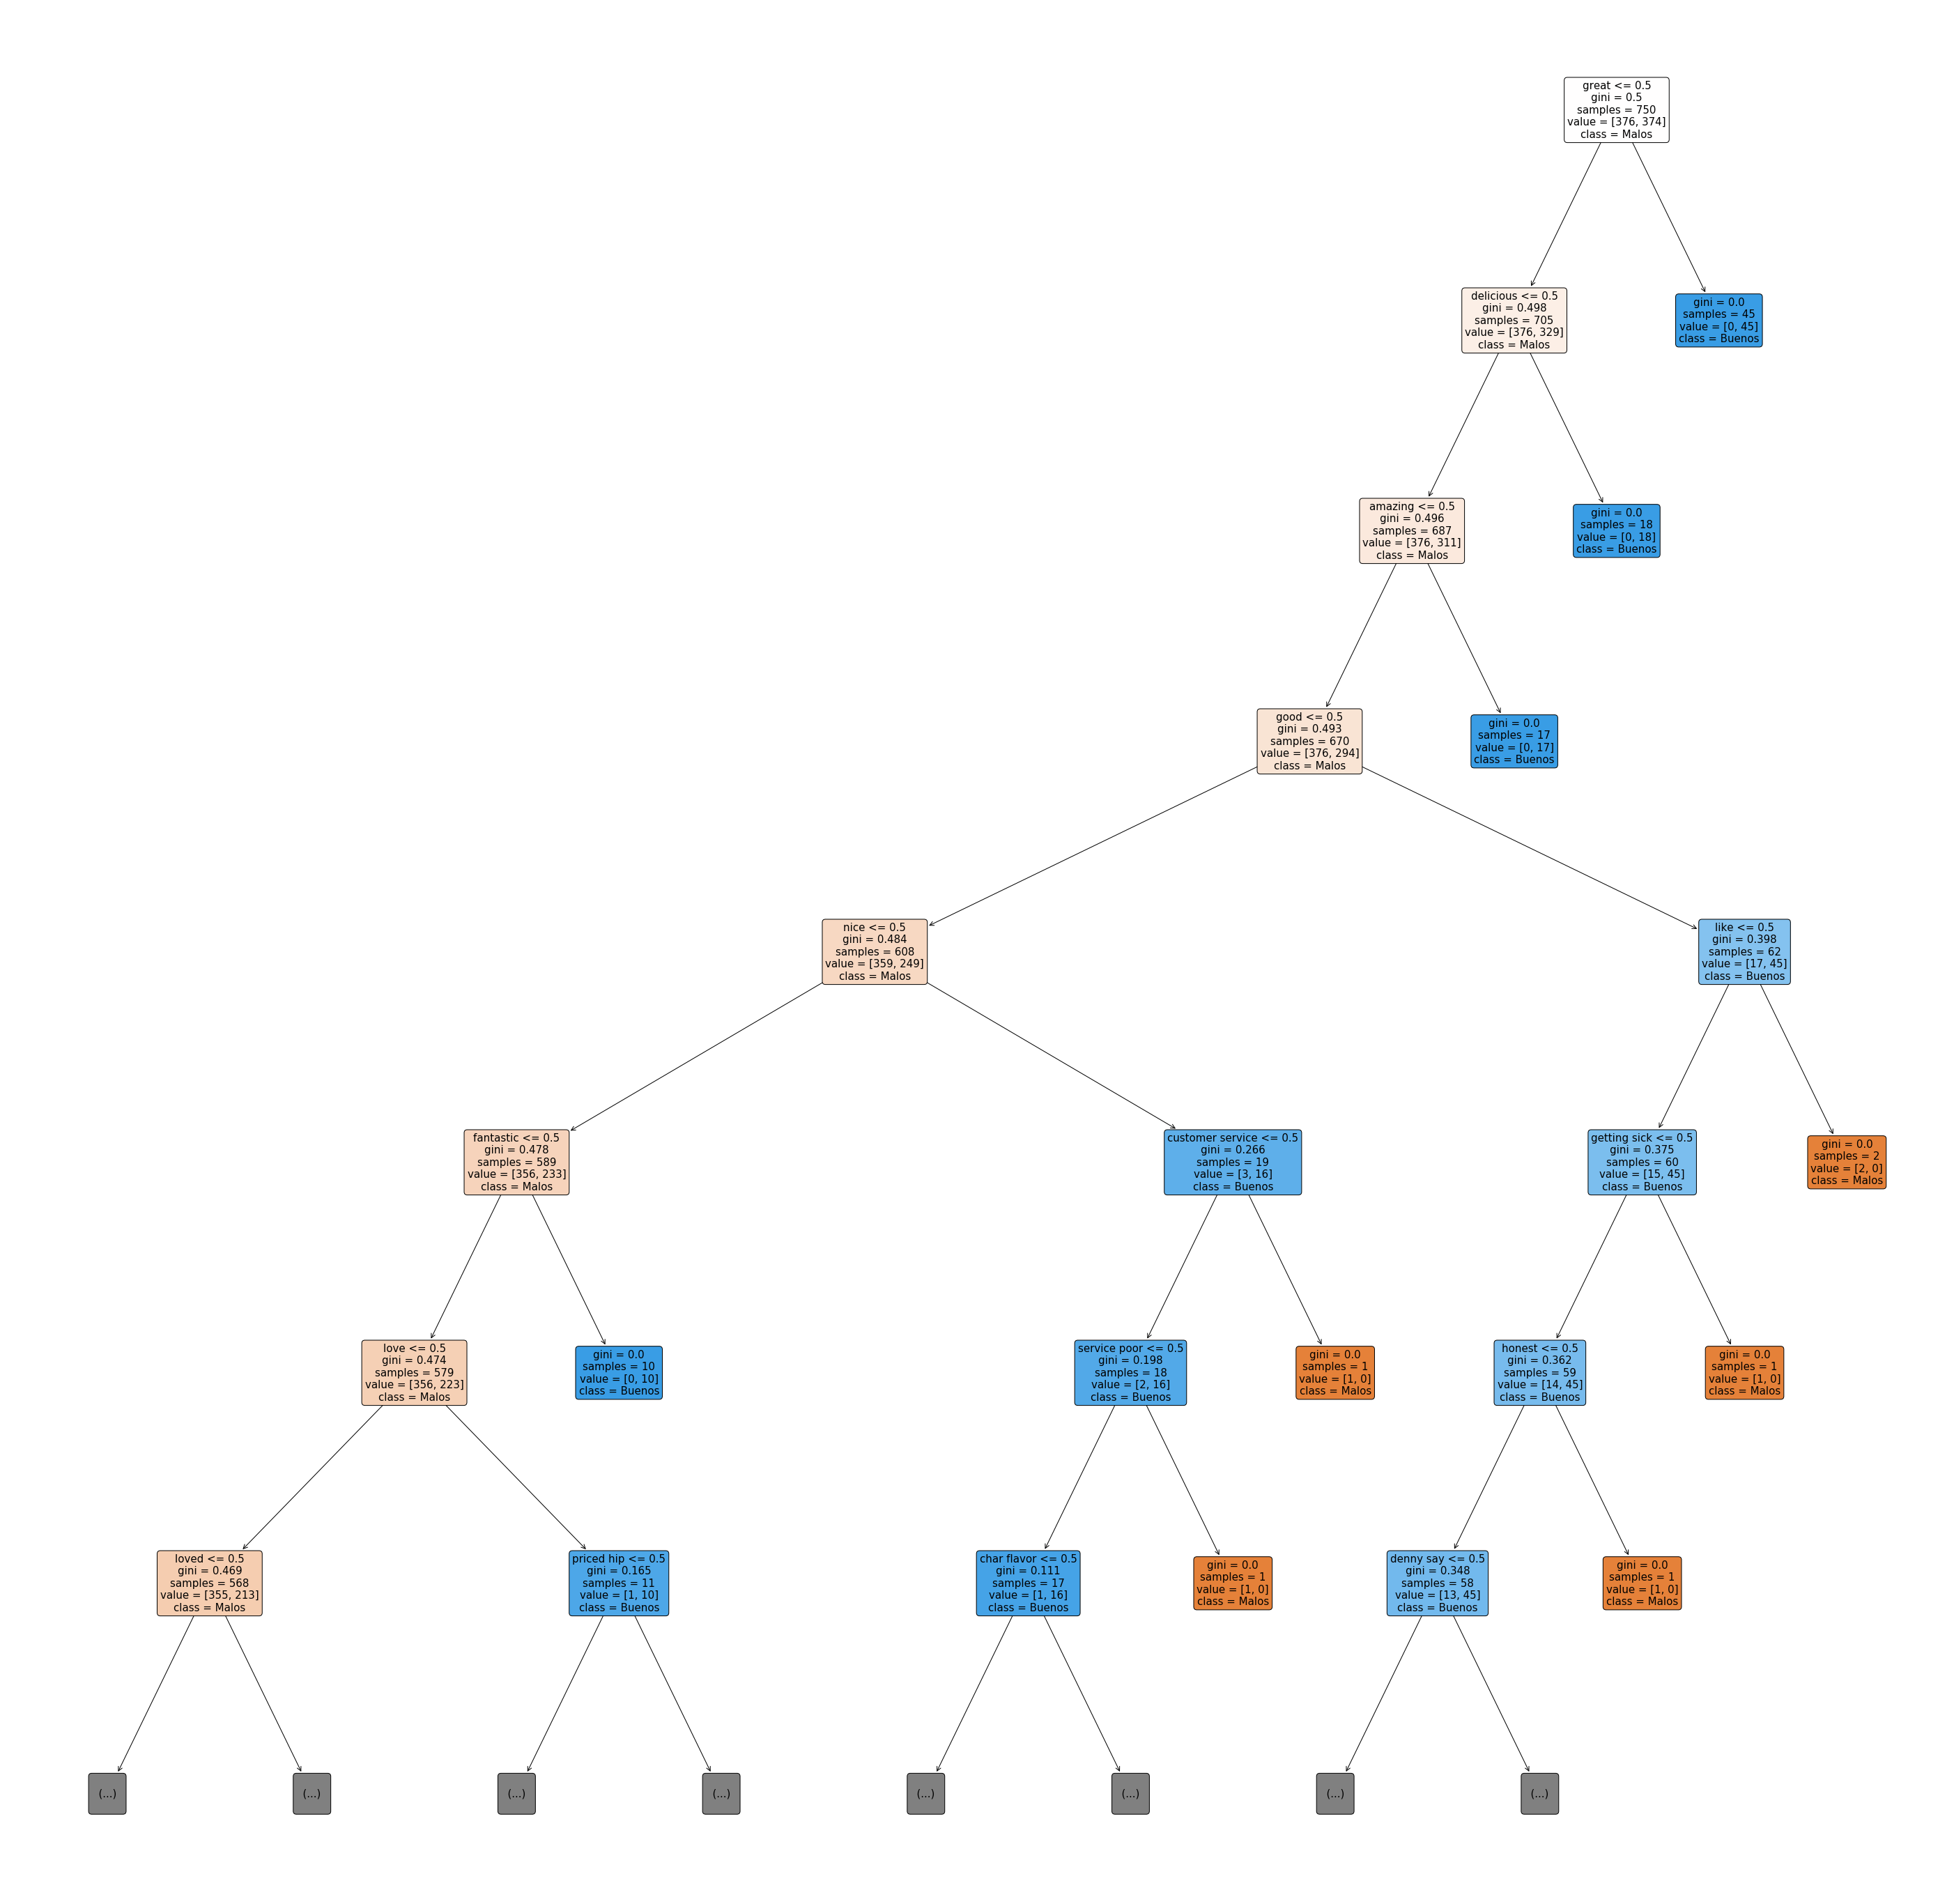

In [ ]:
max_depth = 7
print_tree(best_tree_4,vectorizer4.get_feature_names(),max_depth)

En los 3 primeros niveles del árbol se crean 3 nodos puros con bastantes elementos de críticas positivas con las palabras "great", "delicious" y "amazing". A partir de ese nivel cada vez cuesta más hacer las divisiones para conseguir nodos puros.  En la rama de "love" sigue habiendo nodos impuros con gran cantidad de elementos. En el resto del árbol los nodos puros se componen de muy pocos elementos y hay mayor cantidad de nodos impuros. 

El árbol sí que tiene sentido con la precisión y exhaustividad de los resultados. Acierta las críticas positivas con mucha precisión como se ve en los 3 primeros niveles del árbol. En cambio tiene poca exhaustividad ya que en los siguientes niveles las palabras no tienen tanto poder discriminatorio y son, la mayoría, de sentimiento negativo. Eso hace que empiece a asignar gran parte de las críticas a opiniones negativas.

### Analizar frases falsas positivas y falsas negativas

**Mejor árbol de decisión (monogramas,bigramas y valores binarios)**


Críticas falsas positivas
- 1. "He was extremely rude and really, there are so many other restaurants I would love to dine at during a weekend in Vegas."
- 2. "Now the burgers aren't as good, the pizza which used to be amazing is doughy and flavorless."

Estas frases contienen las palabra que más se utilizan en opiniones positivas. Además estas palabras son de las que tienen mayor poder discriminatorio. 1. "love" 2. "good" y "amazing".

Críticas falsas negativas
- 1. "When I'm on this side of town, this will definitely be a spot I'll hit up again!"
- 2. "I miss it and wish they had one in Philadelphia!"

En estas frases no aparece ninguna de las 25 palabras con mayor poder discrimminatorio. Sabemos que a partir de la número 16 ya no tienen un poder discriminatorio con un criterio fiable. Al ser la mayoría de las palabras con mayor poder discriminatorio positivas y no aparecer en estas frases, suponemos que el clasificador las clasifica como negativas. 

Para mejorar este clasificador creo que bastaría con tener más datos de entrenamiento para tener más palabras con mejor criterio a la hora de discriminar y así deshacernos de las palabras sin sentimiento.

In [ ]:
print_top25_features_in_trees(vectorizer4, best_tree_4)

Top 25 features in the tree

great / good / delicious / amazing / fantastic / nice / awesome / friendly / excellent / loved / perfect / love / happy / best / like / helpful / char flavor / priced hip / service poor / gas station / customer service / cheated wasting / bad food / good way / bring small


**Mejor Naive Bayes (bigramas y valores binarios)**


Críticas falsas positivas
- 1. "I will never go back to this place and will never ever recommended this place to anyone!"
- 2. "There is nothing authentic about this place."

Frase 1: ['place' 'recommended'], Frase 2: ['authentic' 'place']

Aquí el clasificador sabe que 'place' se encuentra mayoritariamente en las opiniones negativas, pero también tiene mucha frecuencia en las positivas. Al contener 'recommended' y 'authentic' en las frases asume que es un caso en el que place está presente en una frase positiva.

Críticas falsas negativas
- 1. "The goat taco didn't skimp on the meat and wow what FLAVOR!"
- 2. "Very convenient, since we were staying at the MGM!"

Frase 1:  ['didn' 'flavor' 'meat' 'taco' 'wow'], Frase 2: ['convenient' 'staying']

In [ ]:
names =["Malos","Buenos"]
print_top25_features_per_class_in_NB(vectorizer4,naive_bayes_4, names)

Top 25 features per class

Malos: food / place / service / like / good / time / don / won / ve / got / bad / worst / just / minutes / came / wasn / disappointed / going / eat / think / pretty / wait / did / way / ll 

Buenos: good / great / food / place / service / delicious / time / amazing / really / nice / best / friendly / just / like / love / vegas / restaurant / awesome / fantastic / staff / excellent / fresh / experience / loved / menu 



Si observamos las palabras de la frase 1 nos damos cuenta de que todas menos 'wow' tienen un sentimiento negativo o son sin sentimiento.En la frase 2 ambas palabras tienen pueden tener un sentimiento positivo o uno negativo (en el conjuto de las 1000 opiniones). Pero como estas palabras han aparecido más en palabras con sentimiento negativo,entonces la parte de entrenamiento contiene 'convenient' y 'staying' con sentimiento negativo.

Para mejorar esto, al igual que con el árbol, necesitaríamos más datos de entrenamiento para que empiece a quedarse con las relevantes, y se dé cuenta el clasificador de cuales son las palabras que no tienen sentimiento, o aquellas que aparecen en muchos mensajes de ambos sentimientos y no son válidas para clasificar ese comentario.